# Monitored SIS-R

In [1]:
# SIR as a compartmented model
#
# Copyright (C) 2017--2022 Simon Dobson
#
# This file is part of epydemic, epidemic network simulations in Python.
#
# epydemic is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# epydemic is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with epydemic. If not, see <http://www.gnu.org/licenses/gpl.html>.

import sys
from typing import Dict, Any
if sys.version_info >= (3, 8):
    from typing import Final
else:
    # backport compatibility with older typing
    from typing_extensions import Final
from epydemic import CompartmentedModel


class MonitoredSIS_R(CompartmentedModel):
    '''The Susceptible-Infected-Removed :term:`compartmented model of disease`.
    Susceptible nodes are infected by infected neighbours, and recover to
    removed.'''

    # Model parameters
    P_INFECTED: Final[str] = 'epydemic.sir.pInfected'  #: Parameter for probability of initially being infected.
    P_INFECT: Final[str] = 'epydemic.sir.pInfect'      #: Parameter for probability of infection on contact.
    P_REMOVE: Final[str] = 'epydemic.sir.pRemove'      #: Parameter for probability of removal (recovery).
    P_RESUSCEPT: Final[str] = 'epydemic.sir.pResuscept'    #: Parameter for probability of losing immunity


    # Possible dynamics states of a node for SIR dynamics
    SUSCEPTIBLE: Final[str] = 'epydemic.sir.S'         #: Compartment for nodes susceptible to infection.
    INFECTED: Final[str] = 'epydemic.sir.I'            #: Compartment/event name for nodes infected.
    REMOVED: Final[str] = 'epydemic.sir.R'             #: Compartment/event name for nodes recovered/removed.
    RESUSCEPT: Final[str] = 'RS'              #: Compartment/event name for returning to susceptible.

    # Locus containing the edges at which dynamics can occur
    SI: Final[str] = 'epydemic.sir.SI'                 #: Edge able to transmit infection.

    def __init__(self):
        super().__init__()

    def build(self, params: Dict[str, Any]):
        '''Build the SIR model.

        :param params: the model parameters'''
        super().build(params)

        pInfected = params[self.P_INFECTED]
        pInfect = params[self.P_INFECT]
        pRemove = params[self.P_REMOVE]
        pResuscept = params[self.P_RESUSCEPT]

        self.addCompartment(self.SUSCEPTIBLE, 1 - pInfected)
        self.addCompartment(self.INFECTED, pInfected)
        self.addCompartment(self.REMOVED, 0.0)

        self.trackEdgesBetweenCompartments(self.SUSCEPTIBLE, self.INFECTED, name=self.SI)
        self.trackNodesInCompartment(self.SUSCEPTIBLE)
        self.trackNodesInCompartment(self.INFECTED)
        self.trackNodesInCompartment(self.REMOVED)
        self.trackNodesInCompartment(self.RESUSCEPT)
        
        self.addEventPerElement(self.SI, pInfect, self.infect, name=self.INFECTED)
        self.addEventPerElement(self.INFECTED, pRemove, self.remove, name=self.REMOVED)
        self.addEventPerElement(self.INFECTED, pResuscept, self.resuscept, self.RESUSCEPT)

    def infect(self, t: float, e: Any):
        '''Perform an infection event. This changes the compartment of
        the susceptible-end node to :attr:`INFECTED`. It also records the
        first occupation time for the edge transmiting the infection,
        and the first hitting time for the infected node.

        :param t: the simulation time
        :param e: the edge transmitting the infection, susceptible-infected'''
        (n, _) = e
        self.changeCompartment(n, self.INFECTED)
        self.markOccupied(e, t, firstOnly=True)
        self.markHit(n, t, firstOnly=True)

    def remove(self, t: float, n: Any):
        '''Perform a removal event. This changes the compartment of
        the node to :attr:`REMOVED`.

        :param t: the simulation time (unused)
        :param n: the node'''
        self.changeCompartment(n, self.REMOVED)

    def resuscept(self, t: float, n: Any):
        '''Perform a re-susceptibility event. This changes the compartment of
        the node from :attr:`REMOVED` to :attr:`SUSCEPTIBLE`.

        :param t: the simulation time (unused)
        :param n: the node'''
        self.changeCompartment(n, self.SUSCEPTIBLE)

In [8]:
from epydemic import ERNetwork, StochasticDynamics, Monitor, ProcessSequence

params = dict()

# use an ER network as the substrate
params[ERNetwork.N] = 10000
params[ERNetwork.KMEAN] = 5

# set the parameters the same as above
params[MonitoredSIS_R.P_INFECT] = 0.02    # infection probability
params[MonitoredSIS_R.P_REMOVE] = 0.002   # recovery probability
params[MonitoredSIS_R.P_INFECTED] = 0.01  # initial fraction infected
params[MonitoredSIS_R.P_RESUSCEPT] = 0.01  # resuscept probability

# capture every 10 timesteps
params[Monitor.DELTA] = 10

# build a compund process from the disease and the monitor
p = ProcessSequence([MonitoredSIS_R(), Monitor()])

# run the compound process
e = StochasticDynamics(p, g=ERNetwork())
e.process().setMaximumTime(1000)
rc = e.set(params).run()

In [10]:
N = 10000
kmean = 5
pRecover = 0.002
pInfect = 0.02
pReinfect = 0.01
T = ts[-1]

In [11]:
from epyc import Experiment

res = rc[Experiment.RESULTS]
ts = res[Monitor.OBSERVATIONS]

# Normalizando os dados:
er_sss = list(map(lambda v: v / N, res[Monitor.timeSeriesForLocus(epydemic.SIR.SUSCEPTIBLE)]))
er_iis = list(map(lambda v: v / N, res[Monitor.timeSeriesForLocus(epydemic.SIR.INFECTED)]))
er_rrs = list(map(lambda v: v / N, res[Monitor.timeSeriesForLocus(epydemic.SIR.REMOVED)]))

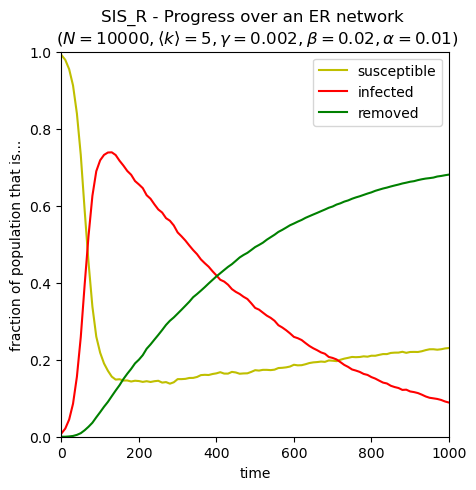

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
plt.title(f'SIS_R - Progress over an ER network \n $(N = {N}, \\langle k \\rangle = {kmean}, \\gamma = {pRecover}, \\beta = {pInfect},\\alpha = {pReinfect})$')
plt.xlabel('time')
ax.set_xlim([0, T])
plt.ylabel('fraction of population that is...')
ax.set_ylim([0.0, 1.0])
plt.plot(ts, er_sss, 'y', label='susceptible')
plt.plot(ts, er_iis, 'r', label='infected')
plt.plot(ts, er_rrs, 'g', label='removed')
plt.legend(loc = 'upper right')
plt.savefig("Monitored_SIS_R_ERnetwork.pdf")